# Lensed QSO experiements with simulations

Based on simulated Gaia catalogue with QSO and lenses produced by Alex Bombrun.



In [22]:
import os
import numpy as np

from astropy.table import Table

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.coordinates import SkyCoord 
import astropy.units as u

from sklearn.neighbors import BallTree
#from IPython.display import Math

D2R = np.pi/180.0

wdir = os.path.expanduser('~') + '/Dropbox/Work/Gaia-QSO'

In [31]:
# read the simulated catalogue
t = Table.read('{}/simDataSet1.csv.gzip'.format(wdir),format='ascii.csv')
nt = len(t)
# now check how many are type 'Lensed QSO'
i_lqso = t['type'] == 'LQSO'
tlens = t[i_lqso]
nlens = len(tlens)
#
i_qso = t['type'] == 'QSO'
tqso = t[i_qso]
nqso = len(tqso)
#
i_star = t['type'] == 'STAR'
tstar = t[i_star]
nstar = len(tstar)
print ("Out of {} entries in the table, {} are with type lens (LQSO)".format(nt,nlens))
print ("Out of {} entries in the table, {} are with type QSO".format(nt,nqso))
print ("Out of {} entries in the table, {} are with type STAR".format(nt,nstar))

Out of 418012 entries in the table, 260 are with type lens (LQSO)
Out of 418012 entries in the table, 393907 are with type QSO
Out of 418012 entries in the table, 23845 are with type STAR


## Proper motion distribution and errors

### The distribution of the RA and Dec proper motion.

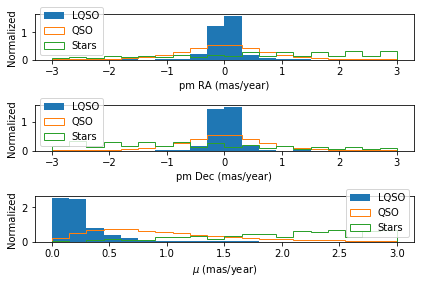

The LQSO with mu <= 1 are 255 (98.1)


In [39]:
# now the proper motion distribution for each class

#
mu = np.sqrt(t['pmra']**2 + t['pmdec']**2)
# propagate the errors, assuming pmra_error and pmdec_errors are uncorrelated
mu_error = np.sqrt((t['pmra']*t['pmra_error']/mu)**2 + (t['pmdec']*t['pmdec_error']/mu)**2)
#

fig, axes = plt.subplots(nrows=3, ncols=1)
ax0, ax1, ax2 = axes.flatten()

ax0.hist(tlens['pmra'],bins=20,range=(-3,3),density=True,label='LQSO')
ax0.hist(tqso['pmra'],bins=20,range=(-3,3),density=True,histtype='step', stacked=True, fill=False,label='QSO')
ax0.hist(tstar['pmra'],bins=20,range=(-3,3),density=True,histtype='step', stacked=True, fill=False,label='Stars')
ax0.set_xlabel('pm RA (mas/year)')
ax0.set_ylabel('Normalized')
ax0.legend()
#
ax1.hist(tlens['pmdec'],bins=20,range=(-3,3),density=True,label='LQSO')
ax1.hist(tqso['pmdec'],bins=20,range=(-3,3),density=True,histtype='step', stacked=True, fill=False,label='QSO')
ax1.hist(tstar['pmdec'],bins=20,range=(-3,3),density=True,histtype='step', stacked=True, fill=False,label='Stars')
ax1.set_xlabel('pm Dec (mas/year)')
ax1.set_ylabel('Normalized')
ax1.legend()

ax2.hist(mu[i_lqso],bins=20,range=(0,3),density=True,label='LQSO')
ax2.hist(mu[i_qso],bins=20,range=(0,3),density=True,histtype='step', stacked=True, fill=False,label='QSO')
ax2.hist(mu[i_star],bins=20,range=(0,3),density=True,histtype='step', stacked=True, fill=False,label='Stars')
ax2.set_xlabel('$\mu$ (mas/year)')
ax2.set_ylabel('Normalized')
ax2.legend()

fig.tight_layout()
plt.show()
#
icheck = np.where(mu[i_lqso] <= 1.5)[0]
print ("The LQSO with mu <= 1.5 are {} ({:.1f})".format(len(icheck),100*len(icheck)/nlens))

The three normalized distributions of the RA nd Dec proper motions are clearly different. No need for any statistical test to prove that.

### Proper motion uncertainties for simulated LQSO

Stats: RA PM/Delta_PM <= 2.0  are 247 out of 260 (95.0 %)
Stats: Dec PM/Delta_PM <= 2.0  are 247 out of 260 (95.0 %)


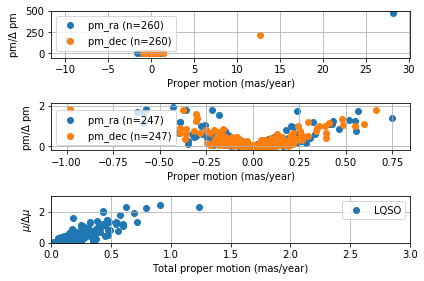

In [51]:
# now the proper motion errors for lenses
#
t_pmra = np.abs(tlens['pmra']/tlens['pmra_error'])
t_pmdec = np.abs(tlens['pmdec']/tlens['pmdec_error'])
#
nra = len(t_pmra)
ndec = len(t_pmdec)
#
fig, axes = plt.subplots(nrows=3, ncols=1)
ax0, ax1, ax2 = axes.flatten()
ax0.scatter(tlens['pmra'],t_pmra,label='pm_ra (n={})'.format(nra))
ax0.scatter(tlens['pmdec'],t_pmdec,label='pm_dec (n={})'.format(ndec))
ax0.set_xlabel('Proper motion (mas/year)')
ax0.set_ylabel('pm/$\Delta$ pm')
ax0.grid(True)
ax0.legend(loc=2)
#
# now those with SNR >= threshold
#
pm_limit_snr = 2.0
ix1 = np.where(t_pmra <= pm_limit_snr)[0]
nx1 = len(np.where(ix1)[0])
ix2 = np.where(t_pmdec <= pm_limit_snr)[0]
nx2 = len(np.where(ix2)[0])
#
print ("Stats: RA PM/Delta_PM <= {}  are {} out of {} ({:.1f} %)".format(pm_limit_snr,nx1,len(t_pmra),100*nx1/len(t_pmra)))
print ("Stats: Dec PM/Delta_PM <= {}  are {} out of {} ({:.1f} %)".format(pm_limit_snr,nx2,len(t_pmdec),100*nx2/len(t_pmdec)))
#
ax1.scatter(tlens['pmra'][ix1],t_pmra[ix1],label='pm_ra (n={})'.format(len(np.where(ix1)[0])))
ax1.scatter(tlens['pmdec'][ix2],t_pmdec[ix2],label='pm_dec (n={})'.format(len(np.where(ix2)[0])))
ax1.set_xlabel('Proper motion (mas/year)')
ax1.set_ylabel('pm/$\Delta$ pm')
ax1.grid(True)
ax1.legend()
# now mu
#ax2.scatter(mu[i_qso],mu[i_qso]/mu_error[i_qso],label='QSO')
ax2.scatter(mu[i_lqso],mu[i_lqso]/mu_error[i_lqso],label='LQSO')
ax2.set_xlabel('Total proper motion (mas/year)')
ax2.set_ylabel('$\mu/\Delta \mu$')
ax2.set_xlim((0.0,3.0))
ax2.set_ylim((0.0,3.0))
ax2.grid(True)
ax2.legend()
fig.tight_layout()
plt.show()

Almost all lenses (247 out of 260) have very uncertain proper motions, compatible with zero: [-0.5,0.5] mas/year.

## Parallax

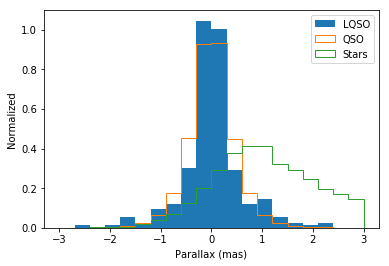

In [5]:
#
# parallax histogram for the 3 classes
#
plt.hist(tlens['parallax'],bins=20,range=(-3,3),density=True,label='LQSO')
plt.hist(tqso['parallax'],bins=20,range=(-3,3),density=True,histtype='step', stacked=True, fill=False,label='QSO')
plt.hist(tstar['parallax'],bins=20,range=(-3,3),density=True,histtype='step', stacked=True, fill=False,label='Stars')
plt.xlabel('Parallax (mas)')
plt.ylabel('Normalized')
plt.legend()
plt.show()

As expected, the parallax distribution for the LQSO and QSO are quite similar and compatible with zero [-1.0,1.0] mas.

Max SNR for LQSO parallaxes is 2.5229497119590123
Max SNR for QSO parallaxes is 4.636350449775345


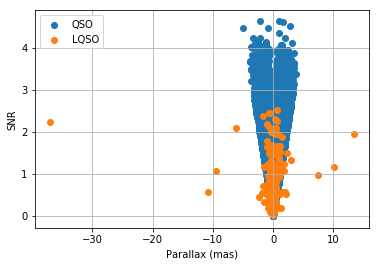

In [6]:
#
# now the parallax distribution for lenses
#
t_prlx = np.abs(tlens['parallax']/tlens['parallax_error'])
t_prlx_qso = np.abs(tqso['parallax']/tqso['parallax_error'])
#
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(tqso['parallax'],t_prlx_qso,label='QSO')
ax.scatter(tlens['parallax'],t_prlx,label='LQSO')
ax.set_xlabel('Parallax (mas)')
ax.set_ylabel('SNR')
ax.grid(True)
ax.legend(loc=2)
print ("Max SNR for LQSO parallaxes is {}".format(np.max(t_prlx)))
print ("Max SNR for QSO parallaxes is {}".format(np.max(t_prlx_qso)))
plt.show()

Conclusion: the LQSO parallaxes should be zero withi the uncertainties. But there are a number of outliers (n=7) in the LQSO sample that may need further investigation.

## Pairwise sky separation of the LQSO

Now we select all lensed sources with one qsoid, i.e. for each lensed system we calculate the pair distances.

Of all LQSO sources (n=260), 100 are with a unique qsoid


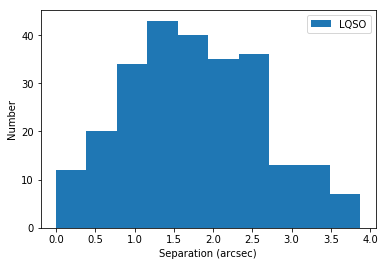

In [7]:
# now extract the unique qsoid
#
qso = np.unique(tlens['qsoid'])
nqso = len(qso)
print ("Of all LQSO sources (n={}), {} are with a unique qsoid".format(nlens,nqso))
#
# now we'll loop over the unique qso and extract all the distances
sep = []
for iqso in qso:
    ix = np.where(tlens['qsoid'] == iqso)[0]
    nx = len(ix)
    tx = tlens[ix]
    for j in np.arange(nx-1):
        c1 = SkyCoord(tx['ra'][j],tx['dec'][j],frame='icrs',unit='deg')
        for k in np.arange(j+1,nx):
            c2 = SkyCoord(tx['ra'][k],tx['dec'][k],frame='icrs',unit='deg')
            sep.append(c1.separation(c2).value*3600.0)

plt.hist(sep,label='LQSO')
plt.xlabel('Separation (arcsec)')
plt.ylabel('Number')
plt.legend()
plt.show()

All LQSO are within 4 arcsec. So, this could be the first criterium when searching for LQSO candidates.

## Astrometric colour distribution

This the distribution of the pairwise differences in astrometric colour for all LQSO sources.


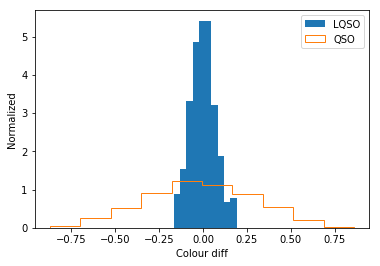

Min,max of the colour differences for LQSO:  -0.16674542619871868 0.1910348260804271


In [8]:
# astrometric colour distribution
colx = []
# LQSO
for iqso in qso:
    ix = np.where(tlens['qsoid'] == iqso)[0]
    nx = len(ix)
    tx = tlens[ix]
    for j in np.arange(nx-1):
        c1 = tx['astrometric_pseudo_colour'][j]
        for k in np.arange(j+1,nx):
            c2 = tx['astrometric_pseudo_colour'][k]
            colx.append(c2-c1)
# QSO
colqso = []
for i in np.arange(nqso-1):
    c1 = tqso['astrometric_pseudo_colour'][i]
    for j in np.arange(i+1,nqso):
            c2 = tqso['astrometric_pseudo_colour'][j]
            colqso.append(c2-c1)
plt.hist(colx,label='LQSO',density=True)
plt.hist(colqso,density=True,histtype='step', stacked=True, fill=False,label='QSO')
plt.xlabel('Colour diff')
plt.ylabel('Normalized')
plt.legend()
plt.show()
print ("Min,max of the colour differences for LQSO: ",np.min(colx),np.max(colx))

The colour difference of QSOs is different.

## g Mag distribution

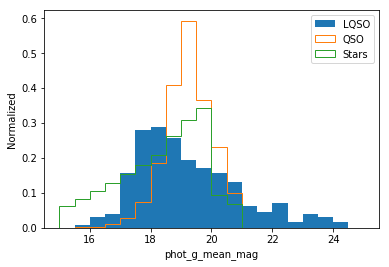

In [9]:
plt.hist(tlens['phot_g_mean_mag'],bins=20,range=(15.0,25.0),density=True,label='LQSO')
plt.hist(tqso['phot_g_mean_mag'],bins=20,range=(15.0,25.0),density=True,histtype='step', stacked=True, fill=False,label='QSO')
plt.hist(tstar['phot_g_mean_mag'],bins=20,range=(15.0,25.0),density=True,histtype='step', stacked=True, fill=False,label='Stars')
plt.xlabel('phot_g_mean_mag')
plt.ylabel('Normalized')
plt.legend()
plt.show()

## Pairwise magnitude distribution

For all LQSO, the pairwise difference in colour

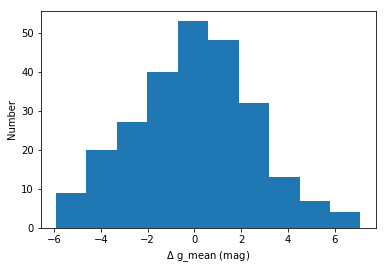

Min, max of pairwise gMag differences for LQSO:  -5.9144442994034385 7.097533747044654


In [10]:
# g_mag diff (colour) distribution
colx = []
for iqso in qso:
    ix = np.where(tlens['qsoid'] == iqso)[0]
    nx = len(ix)
    tx = tlens[ix]
    for j in np.arange(nx-1):
        c1 = tx['phot_g_mean_mag'][j]
        for k in np.arange(j+1,nx):
            c2 = tx['phot_g_mean_mag'][k]
            colx.append(c2-c1)

plt.hist(colx)
plt.xlabel('$\Delta$ g_mean (mag)')
plt.ylabel('Number')
plt.show()
print ("Min, max of pairwise gMag differences for LQSO: ",np.min(colx),np.max(colx))

The magnitudes are not constraining the LQSO. The spread of their magnitudes is quite significant.

## Explore the simulated catalogue

Let's now explore the simulated catalogue incorporating the following criteria:

1. Filter out the sources in the catalogue, keep only sources with parallax in [-3.0,3.0] mas and parallax SNR < 3.0.
2. For each source in the new table, find all neighbours within 5 arcsec (will use BallTree method).


In [42]:
#
# read the catalogue
#
cat = Table.read('{}/simDataSet1.csv.gzip'.format(wdir),format='ascii.csv')
nc = len(cat)
#
# filtering, keeping those with parallax compatible with zero.
#
ipar = np.logical_and(np.abs(cat['parallax']) < 3.0,np.abs(cat['parallax']/cat['parallax_error']) < 3.0)
cat = cat[ipar]
nt = len(cat)
print ("Will process {} sources out of {} input entries ({:.1f} %)".format(nt,nc,100.0*nt/nc))
#
# calculate the total proper motion
xmu = np.sqrt(cat['pmra']**2 + cat['pmdec']**2)
# propagate the errors, assuming pmra_error and pmdec_errors are uncorrelated
xmu_error = np.sqrt((cat['pmra']*cat['pmra_error']/xmu)**2 + (cat['pmdec']*cat['pmdec_error']/xmu)**2)
#
cat['mu'] = xmu
cat['mu_error'] = xmu_error

Will process 400827 sources out of 418012 input entries (95.9 %)


In [43]:
#
# build the tree
#
X = np.array([cat['ra']*D2R,cat['dec']*D2R]).transpose()
# metric haversine is the distance on a sphere
tree = BallTree(X,leaf_size=10,metric="haversine")
#
# search the tree within 5 arcsec
rlim = 5.0 # arcsec
rlim_deg = rlim/3600.0
rlim_rad = rlim_deg*D2R
#
# select all node which have neighbours within rlim_rad
#
nnb = tree.query_radius(X,r=rlim_rad,count_only=True)
ix = np.where(nnb > 1)[0]
nk = len(ix)
print ("{} sources have more than one neighbour within {} arcsec".format(nk,rlim))
tk = cat[ix]

14360 sources have more than one neighbour within 5.0 arcsec


In [53]:
#
# now find those with astrometric colour diff in +/- 0.2.
#
# make all sky coordinates form the catalogue
#
c1 = SkyCoord(ra=tk['ra'],dec=tk['dec'],frame='icrs',unit='deg')
srcid = tk['col0']
xclass = tk['type']
# now loop over all sources
lens = {}
doneSrc = {}
#
fout = open('{}/results_test2.txt'.format(wdir),'w')
#
nxtot = 0
nxqso = 0
nxlqso = 0
nxstar = 0
#
mu_limit = 1.5
for i in np.arange(nk):
    # already processed
    if ((srcid[i] in lens.keys()) or (srcid[i] in doneSrc.keys())):
        #print ("*** Skipping {} as already done".format(i))
        continue
    #print ("Doing {}/{}".format(i,nk))
    ci = SkyCoord(ra=tk['ra'][i],dec=tk['dec'][i],frame='icrs',unit='deg')
    coli = tk['astrometric_pseudo_colour'][i]
    mui = tk['mu'][i]
    mui_err = tk['mu_error'][i]
    #
    # skipping those with too high total PM 
    if ((mui > mu_limit) or (mui/mui_err >= 3.0)):
        continue
    d2d = ci.separation(c1)
    c1mask = np.logical_and(d2d <= rlim*u.arcsec,d2d > 0.01*u.arcsec)
    #
    ix1 = np.where(c1mask)[0]
    nq = len(ix1)
    if (nq < 1):
        continue
    #
    tq = tk[ix1]
    #print ("Source {} has {} neighbours within {} arcsec".format(srcid[i],nq,rlim))
    qq = []
    for j in np.arange(nq):
        dif = coli - tq['astrometric_pseudo_colour'][j]
        if (np.abs(dif) <= 0.2):
            qq.append(tq['col0'][j])
            doneSrc[tq['col0'][j]] = srcid[i]
    #
    if (len(qq) > 0):
        lens[srcid[i]] = qq
        #print ('Source {} ({}) has a candidate lens neighbours {}, colour difference = {}, distance={}'.format(srcid[i],i,qq,dif,3600.0*d2d[ix1].value))
        print ('Source {} ({},{}) has a candidate lens neighbours {}, colour difference = {}, distance={}'.format(srcid[i],i,xclass[i],qq,dif,3600.0*d2d[ix1].value),file=fout)
        nxtot += 1
        if (xclass[i] == 'LQSO'):
            nxlqso += 1
        if (xclass[i] == 'QSO'):
            nxqso += 1
        if (xclass[i] == 'STAR'):
            nxstar += 1
fout.close()
print ("all done. some statitsics")
print ("Total number of candidate LQSO: ",nxtot)
print ("Of these, simulated LQSO are: ",nxlqso)
print ("    simulated QSO are: ",nxqso)
print ("    simulated Stars are: ",nxstar)


all done. some statitsics
Total number of candidate LQSO:  2655
Of these, simulated LQSO are:  97
    simulated QSO are:  2551
    simulated Stars are:  7


In [54]:
fout.close()

[]